In [40]:
import pinecone
from datasets import load_dataset

pinecone.init(
    api_key="16825179-e09f-4405-b454-53629d6ade00", environment="us-west4-gcp-free"
)

In [41]:
# load the dataset
celeb_faces = load_dataset("ashraq/tmdb-people-image", split="train")
celeb_faces

Found cached dataset parquet (/Users/douglasbudge/.cache/huggingface/datasets/ashraq___parquet/default-f6987358ed4d9f01/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['adult', 'also_known_as', 'biography', 'birthday', 'deathday', 'gender', 'homepage', 'id', 'imdb_id', 'known_for_department', 'name', 'place_of_birth', 'popularity', 'profile_path', 'image'],
    num_rows: 116403
})

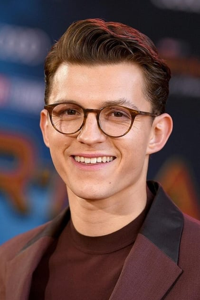

In [42]:
# examine data
celeb = celeb_faces[10]
celeb["image"].resize((200,300))

In [43]:
metadata=celeb_faces.remove_columns(['adult', 'also_known_as', 'biography', 'deathday', 'gender', 'homepage', 'id', 'imdb_id', 'known_for_department', 'image']).to_pandas()
metadata=metadata.fillna("None")

In [44]:
from facenet_pytorch import MTCNN
mtcnn= MTCNN()
img= celeb["image"].copy()
boxes, prob = mtcnn.detect(img)
boxes,prob


(array([[91.48239135742188, 112.33537292480469, 316.8033447265625,
         409.37725830078125]], dtype=object),
 array([0.9999923706054688], dtype=object))

In [45]:
# pass the image or batch of images directly through mtcnn model
face = mtcnn(img)
face.shape

torch.Size([3, 160, 160])

In [46]:
from facenet_pytorch import InceptionResnetV1
import torch

# initialize VGGFace2 model
resnet = InceptionResnetV1(pretrained="vggface2").eval()
# generate embedding for the face extracted using mtcnn above
embedding = resnet(torch.stack([face]))
embedding.shape


torch.Size([1, 512])

In [52]:
import numpy as np

class FacenetEmbedder:
    def __init__(self):
        # set device to use GPU if available
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        # initialize MTCNN model
        self.mtcnn = MTCNN(device=self.device)
        # initialize VGGFace2 model
        self.resnet = InceptionResnetV1(pretrained='vggface2', device=self.device).eval()

    def detect_face(self, batch):
        # get coordinates of the face
        faces = self.mtcnn.detect(batch)
        return faces

    def encode(self, batch):
        # pass the batch of images directly through mtcnn model
        face_batch = self.mtcnn(batch)
        # remove any images that does not contain a face
        face_batch = [i for i in face_batch if i is not None]
        # concatenate face batch to form a single tensor
        aligned = torch.stack(face_batch)
        # if using gpu move the input batch to gpu
        if self.device.type == "cuda": 
            aligned = aligned.to(self.device)
        # generate embedding
        embeddings = self.resnet(aligned).detach().cpu()
        return embeddings.tolist()
    



In [53]:
# intialize the embedder
facenet= FacenetEmbedder()

# test the pipeline with a small batch
batch= celeb_faces[10:20]['image']
len(facenet.encode(batch))


10

In [49]:
# Create vector index
index_name= 'tmdb-people'

# check if index name exists
if index_name not in pinecone.list_indexes():
    #create index if it doesn't exist
    pinecone.create_index(
        index_name,
        dimension= 512,
        metric='cosine'
    )

# connect to created index
index= pinecone.GRPCIndex(index_name)



In [50]:
def reshape(batch):
    batch = [image.convert("RGB").resize((421, 632)) for image in batch]
    return batch

In [55]:
from tqdm.auto import tqdm

# we will use batches of 64
batch_size = 64

for i in tqdm(range(0, len(celeb_faces), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(celeb_faces))
    # extract batch
    batch = celeb_faces[i:i_end]["image"]
    # reshape the images to ensure they all have same shape
    batch = reshape(batch)
    # generate embeddings for batch
    try:
        emb = facenet.encode(batch)
    except:
        pass
    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add metadata
    meta = metadata[i:i_end].to_dict(orient="records")
    # add all to upsert list
    to_upsert = list(zip(ids, emb, meta))
    # upsert/insert these records to pinecone
    _ = index.upsert(vectors=to_upsert)

# # check that we have all vectors in index
index.describe_index_stats()

  0%|          | 0/1819 [00:00<?, ?it/s]